In [157]:
#packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as ls 
from tqdm import tqdm
from scipy.signal import find_peaks
import networkx as nx 
import source_file as sf
import importlib
importlib.reload(sf)


import matplotlib as mpl
mpl.rc('font', size=18)
mpl.rc('legend', fontsize=18)
mpl.rc('legend', numpoints=1)
mpl.rc('legend', handlelength=1.5)
mpl.rc('legend', frameon=False)
#mpl.rc('xtick.major', pad=7)
#mpl.rc('xtick.minor', pad=7)
mpl.rc('lines', lw=2)
mpl.rc('xtick',labelsize =15) 
mpl.rc('ytick',labelsize =15)


plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#### The non-Hermitian Quantum walker

$$ H_{tot} = H_{search} + V, $$

where $V = -i\kappa |w \rangle \langle w |$ and $H_{search} = - \gamma N |s\rangle\langle s| - |w\rangle\langle w | $ with $\kappa > 0$.




Question: What is the effect of the non-hermitian part in the search process, and how one can optimize it for the best search process?

There are three eigenvalues approximately

1) $-\gamma N$
2) $-1 - i\kappa$
3) $0 \quad $ $N - 2 \,\,\text{degenerate}$

The exact values are

1) $ \lambda_- = -\frac{\gamma N + 1 + i \kappa}{2}  - \sqrt{\left( \frac{\gamma N + 1 + i \kappa}{2} \right)^2 - (\gamma N - \gamma)(1 + i \kappa)}$
2) $\lambda_+ = -\frac{\gamma N + 1 + i \kappa}{2}  + \sqrt{\left( \frac{\gamma N + 1 + i \kappa}{2} \right)^2 - (\gamma N - \gamma)(1 + i \kappa)}$
3) $0 \quad $ $N - 2 \,\,\text{degenerate}$

The imaginary part will be responsible for the decrease in population from the target site and increase in population of the detector state. We want to fix $\kappa$ and try to optimize $\gamma$ so that there is maximal decrease in population from the target site.


The eigenvectors for the ground and the first excited states are:

$$|\lambda_\pm \rangle = N_\pm \left(\frac{- \lambda_\pm - \gamma(N -1)}{\gamma \sqrt{N - 1}}, 1\right)^T$$

In [147]:
#parameters
N = 1000
gamma =  2/N
w  = 10
kappa = 0.5

#Hamiltonian matrix
H = sf.H_CG(N,gamma,w,kappa)

#get the eigenvalue and right eigenstates
eigval,eigvec = np.linalg.eig(H)

#get the eigenvalue and left eigenstates
eigval_2,_ = np.linalg.eig(np.transpose(H))

#theoretical computations of the eigenvalues
lambda_plus,lambda_minus = sf.lambda_pm(N,gamma,kappa)


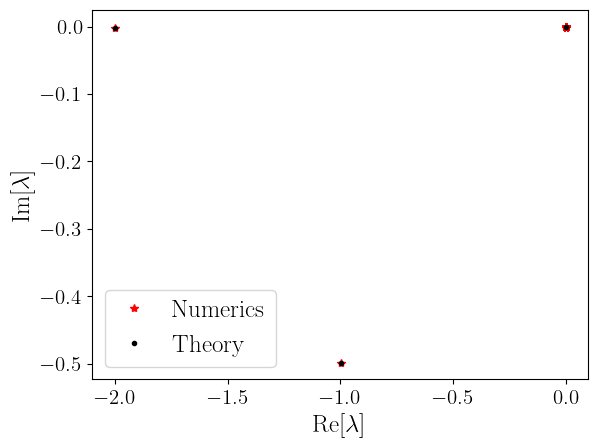

In [148]:
plt.plot(np.real(eigval),np.imag(eigval),'r*',label = 'Numerics')

plt.plot(0,0,'k.')
plt.plot(np.real(lambda_plus),np.imag(lambda_plus),'k.', label = 'Theory')
plt.plot(np.real(lambda_minus),np.imag(lambda_minus),'k.')

plt.legend(frameon = True)

plt.xlabel(r'Re$[\lambda]$')
plt.ylabel(r'Im$[\lambda]$')

plt.show()

#### The zero eigenvalue modes

In [149]:
# Sort the eigenvalues and eigenvectors
sorted_indices = np.argsort(np.real(eigval))  # Get indices for sorting eigenvalues
eigval_sorted = eigval[sorted_indices]  # Sort eigenvalues
eigvec_sorted = eigvec[:,sorted_indices]  # Reorder eigenvectors accordingly    


#compute the overlap with the initial state
psi_0 = (1.0/np.sqrt(N))*np.ones((N,1)) #initial state


sum = 0
for i in range(2,N):
    sum += np.abs(np.vdot(eigvec_sorted[:,i],psi_0))**2
    #print(np.abs(np.vdot(eigvec_sorted[:,i],psi_0))**2)

print(sum)



2.6373973760254133e-29


#### Survival Probability

The zero eigenvalue modes have negligible overlap with the initial state. Numerically it is of order ($10^{-29}$). This led to the expression of survival probability to be 


$$S(t) \approx e^{2 \rm{Im} (\lambda_-) t}\, |\langle \lambda_-|s \rangle|^2  + e^{2 \rm{Im} (\lambda_+) t}\, |\langle \lambda_+|s \rangle|^2 $$

The behavior of survival probability thus depends on these two terms. Both overlaps and the rate of decay depends on $\gamma$ and $\kappa$. 

In [221]:
#parameters
N = 500
w  = 10
kappa = np.linspace(0.001,1,500)
#gamma = np.linspace(0.0001,2/N,100)
gamma = [1.3/N]

E0s_t = np.zeros(len(kappa), dtype = complex)
E1s_t = np.zeros(len(kappa), dtype = complex)

for i in range(len(kappa)):

    #theoretical computations of the overlaps
    E0s_t[i],E1s_t[i],_,_ = sf.overlap_CG_theory(N,gamma,w,kappa[i])

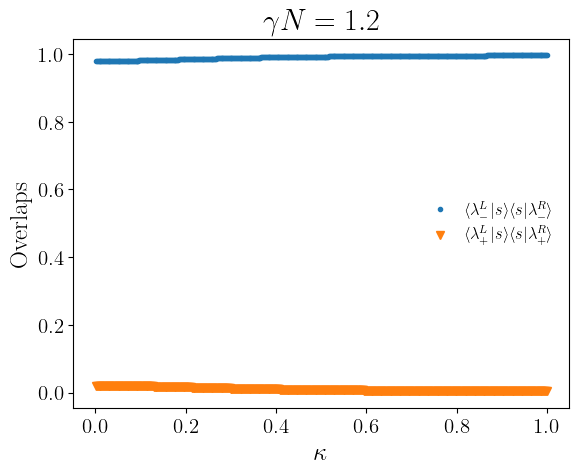

In [222]:
plt.plot(kappa, abs(E0s_t),'.',label = r'$\langle \lambda_-^L | s \rangle \langle s | \lambda_-^R \rangle$')
plt.plot(kappa, abs(E1s_t),'v',label = r'$\langle \lambda_+^L | s \rangle \langle s | \lambda_+^R \rangle$')

plt.legend(fontsize = 12)
plt.xlabel(r'$\kappa$')
plt.ylabel(r'Overlaps')
plt.title(f'$\\gamma N = {1.2}$')

#plt.savefig(f'../Figures/Overlap_CG/Overlap_gammaN{2}.pdf',bbox_inches = 'tight',dpi =600)
plt.show()


#### Analysis  and the imaginary part of the ground state and first excited state eigenvalues

For $\gamma N \ll 1$, the survival probability is governed by

$$ S(t) \approx e^{2 \rm{Im} (\lambda_+) t}$$

For $\gamma N \gg 1$, the survival probability is governed by

$$ S(t) \approx e^{2 \rm{Im} (\lambda_-) t}$$

For $\gamma N = 1$, it is governed by both overlap and the decay rate, but for large $\kappa$, it is again given by the expression of $S(t)$ for the case of $\gamma N \ll 1$.

In [468]:
#parameters
N = 500
w  = 10
kappa = [0.01,0.1,0.25,0.5,0.75,1,10]
gamma = np.linspace(0.1/N,0.9/N,10)

lambda_plus = np.zeros((len(kappa), len(gamma)), dtype = complex)

for j in range(len(kappa)):
    for i in range(len(gamma)):

        #Hamiltonian matrix
        H = sf.H_CG(N,gamma[i],w,kappa[j])

        #get the eigenvalue and right eigenstates
        eigval,_ = np.linalg.eig(H)
        sorted_indices = np.argsort(np.real(eigval))  # Get indices for sorting eigenvalues
        eigval_sorted = eigval[sorted_indices] 

        lambda_plus[j,i] = eigval_sorted[1]

                
        #theoretical computations of the eigenvalues
        #lambda_plus[j,i],_ = sf.lambda_pm(N,gamma[i],kappa[j])

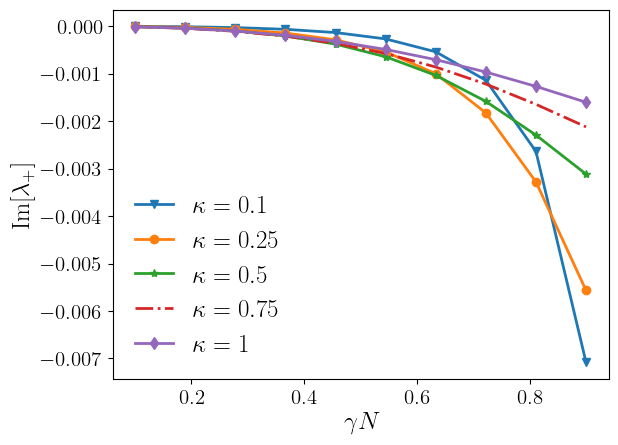

In [469]:
#plt.plot(gamma*N, np.imag(lambda_plus[0]),'-.', label = f'$\\kappa = {kappa[0]}$')
plt.plot(gamma*N, np.imag(lambda_plus[1]),'-v', label = f'$\\kappa = {kappa[1]}$')
plt.plot(gamma*N, np.imag(lambda_plus[2]),'-o', label = f'$\\kappa = {kappa[2]}$')
plt.plot(gamma*N, np.imag(lambda_plus[3]),'-*', label = f'$\\kappa = {kappa[3]}$')
plt.plot(gamma*N, np.imag(lambda_plus[4]),'-.', label = f'$\\kappa = {kappa[4]}$')
plt.plot(gamma*N, np.imag(lambda_plus[5]),'-d', label = f'$\\kappa = {kappa[5]}$')


plt.legend()
plt.ylabel('Im$[\lambda_+]$')
plt.xlabel(r'$\gamma N$')
plt.savefig(f'../Figures/imag_lambda_plus.pdf',bbox_inches ='tight', dpi =600)
plt.show()

In [470]:
#parameters
N = 500
w  = 10
kappa = [0.01,0.1,0.25,0.5,0.75,1,10]
gamma = np.linspace(1.1/N,2/N,10)

lambda_minus = np.zeros((len(kappa), len(gamma)), dtype = complex)

for j in range(len(kappa)):
    for i in range(len(gamma)):

        #Hamiltonian matrix
        H = sf.H_CG(N,gamma[i],w,kappa[j])

        #get the eigenvalue and right eigenstates
        eigval,_ = np.linalg.eig(H)
        sorted_indices = np.argsort(np.real(eigval))  # Get indices for sorting eigenvalues
        eigval_sorted = eigval[sorted_indices] 

        lambda_minus[j,i] = eigval_sorted[0]



        
        #theoretical computations of the eigenvalues
        #_,lambda_minus[j,i] = sf.lambda_pm(N,gamma[i],kappa[j])

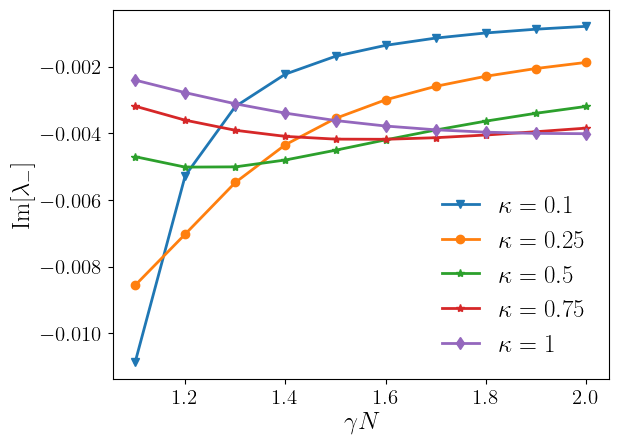

In [471]:
#plt.plot(gamma*N, np.imag(lambda_minus[0]),'.', label = f'$\\kappa = {kappa[0]}$')
plt.plot(gamma*N, np.imag(lambda_minus[1]),'-v', label = f'$\\kappa = {kappa[1]}$')
plt.plot(gamma*N, np.imag(lambda_minus[2]),'-o', label = f'$\\kappa = {kappa[2]}$')
plt.plot(gamma*N, np.imag(lambda_minus[3]),'-*', label = f'$\\kappa = {kappa[3]}$')
plt.plot(gamma*N, np.imag(lambda_minus[4]),'-*', label = f'$\\kappa = {kappa[4]}$')
plt.plot(gamma*N, np.imag(lambda_minus[5]),'-d', label = f'$\\kappa = {kappa[5]}$')
#plt.plot(gamma*N, np.imag(lambda_minus[6]),'-d', label = f'$\\kappa = {kappa[6]}$')

plt.legend()
plt.ylabel('Im$[\lambda_-]$')
plt.xlabel(r'$\gamma N$')

#plt.savefig(f'../Figures/imag_lambda_minus.pdf',bbox_inches ='tight', dpi =600)
plt.show()

#### Check of theoretical survival probability 

There is something missing with the theoretical calculations in the neighbourhood of $\gamma N = 1$. Although, the long time behavior matches and qualitatively it behaves the same, there is a consistent mismatch in the short and intermediate time behavior !!! 

In [368]:
N = 500
w  = 10
kappa = 0.5
gamma = [0.5/N,1.0/N,1.5/N,2.0/N]

T = 400
dt = 0.01
m  = int(T/dt)


s_prob = np.zeros((len(gamma),m))

#target state
ket_w = np.zeros((N,1))
ket_w[w] = 1

for k in tqdm(range(len(gamma))):
    
    #The Hamiltonian
    H =  sf.H_CG(N,gamma[k],w,kappa)

    #initial state
    psi_0 = (1.0/np.sqrt(N))*np.ones((N,1))

    #Initial overlap
 
    s_prob[k,0] = np.abs(np.vdot(psi_0,psi_0))

    #Time Evolution operator
    ut = np.asarray(ls.expm(-(1.0j)*H*dt))

    for j in range(1,m):        

        #wavefunction after time evolution of dt
        psit = ut.dot(psi_0)    

        #survival probability

        s_prob[k,j] = np.abs(np.vdot(psit,psit))

        psi_0 = psit  

100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


In [369]:
gamma = [0.5/N,1.0/N,1.5/N,2.0/N]

#theoretical computations of the overlaps
E0s_t,E1s_t,_,_ = sf.overlap_CG_theory(N,gamma,w,kappa)

lambda_plus = np.zeros(len(gamma), dtype = complex)
lambda_minus = np.zeros(len(gamma), dtype =complex)

for i in range(len(gamma)):
    #theoretical computations of the eigenvalues
    lambda_plus[i],lambda_minus[i] = sf.lambda_pm(N,gamma[i],kappa)

In [370]:
t = np.arange(0,400,0.01)
S_1 = np.zeros(m)
S_2 = np.zeros(m)
S_3 = np.zeros(m)
S_4 = np.zeros(m)

for i in range(m):
    S_1[i] = np.exp(2*np.imag(lambda_minus[0])*t[i])*abs(E0s_t[0])  + np.exp(2*np.imag(lambda_plus[0])*t[i])*abs(E1s_t[0]) 
    S_2[i] = np.exp(2*np.imag(lambda_minus[1])*t[i])*abs(E0s_t[1])  + np.exp(2*np.imag(lambda_plus[1])*t[i])*abs(E1s_t[1]) 
    S_3[i] = np.exp(2*np.imag(lambda_minus[2])*t[i])*abs(E0s_t[2])  + np.exp(2*np.imag(lambda_plus[2])*t[i])*abs(E1s_t[2]) 
    S_4[i] = np.exp(2*np.imag(lambda_minus[3])*t[i])*abs(E0s_t[3])  + np.exp(2*np.imag(lambda_plus[3])*t[i])*abs(E1s_t[3]) 

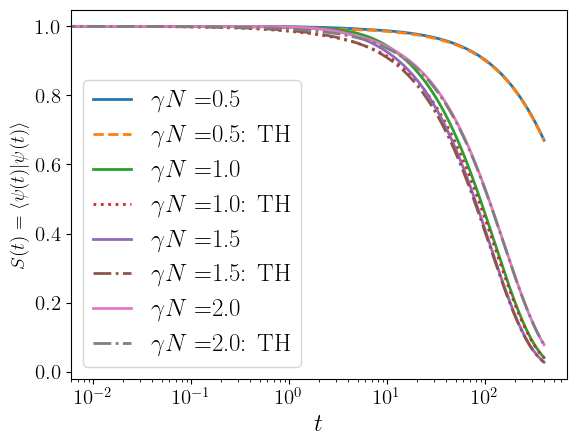

In [371]:
plt.plot(np.arange(m)*dt,s_prob[0],label = f'$\\gamma N=${gamma[0]*N}')
plt.plot(np.arange(m)*dt,S_1,'--',label = f'$\\gamma N=${gamma[0]*N}: TH')


plt.plot(np.arange(m)*dt,s_prob[1],label = f'$\\gamma N=${gamma[1]*N}')
plt.plot(np.arange(m)*dt,S_2,':',label = f'$\\gamma N=${gamma[1]*N}: TH')

plt.plot(np.arange(m)*dt,s_prob[2],label = f'$\\gamma N=${gamma[2]*N}')
plt.plot(np.arange(m)*dt,S_3,'-.',label = f'$\\gamma N=${gamma[2]*N}: TH')

plt.plot(np.arange(m)*dt,s_prob[3],label = f'$\\gamma N=${gamma[3]*N}')
plt.plot(np.arange(m)*dt,S_4,'-.',label = f'$\\gamma N=${gamma[3]*N}: TH')


plt.legend(frameon =True,loc = 'lower left')
plt.xlabel(r'$t$')
plt.ylabel(r'$S(t) = \langle \psi(t)|\psi(t)\rangle$',fontsize = 14)
plt.xscale('log')

plt.savefig(f'../Figures/Surv_Prob_CG/surv_prob_kappa{kappa}.pdf',bbox_inches = 'tight')
plt.show()

#### Overlap of the ground state and first excited state with the target and initial state

In [246]:
#parameters
N = 500
w  = 10
kappa = 1
gamma = np.linspace(0.1/N,2/N,100)

E0s,E1s,E0w,E1w = sf.overlap_CG_numerics(N,gamma,w,kappa)
E0s_t,E1s_t,E0w_t,E1w_t = sf.overlap_CG_theory(N,gamma,w,kappa)

100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


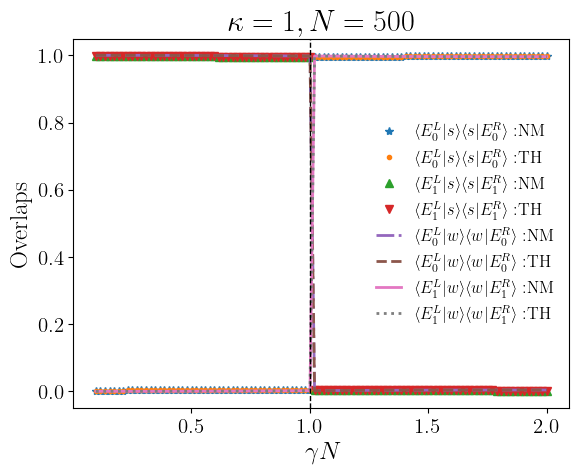

In [247]:
plt.plot(gamma*N, E0s,'*',label = r'$\langle E_0^L | s \rangle \langle s | E_0^R \rangle:$NM')
plt.plot(gamma*N, E0s_t,'.',label = r'$\langle E_0^L | s \rangle \langle s | E_0^R \rangle:$TH')

plt.plot(gamma*N, E1s,'^',label = r'$\langle E_1^L | s \rangle \langle s | E_1^R \rangle:$NM')
plt.plot(gamma*N, E1s_t,'v',label = r'$\langle E_1^L | s \rangle \langle s | E_1^R \rangle:$TH')

plt.plot(gamma*N, E0w,'-.',label = r'$\langle E_0^L | w \rangle \langle w | E_0^R \rangle:$NM')
plt.plot(gamma*N, E0w_t,'--',label = r'$\langle E_0^L | w \rangle \langle w | E_0^R \rangle:$TH')

plt.plot(gamma*N, E1w,'-',label = r'$\langle E_1^L | w \rangle \langle w | E_1^R \rangle:$NM')
plt.plot(gamma*N, E1w_t,':',label = r'$\langle E_1^L | w \rangle \langle w | E_1^R \rangle:$TH')

plt.axvline(1.0,linestyle = '--',color = 'k',linewidth =1)

plt.legend(fontsize = 12)
plt.xlabel(r'$\gamma N$')
plt.ylabel(r'Overlaps')
plt.title(f'$\\kappa = {kappa}, N = {N}$')

plt.savefig(f'../Figures/Overlap_CG/Overlap_k{kappa}_N{N}.pdf',bbox_inches = 'tight',dpi =600)
plt.show()

#### Computing the maximum fidelity and corresponding T_max in the $(\gamma-\kappa)$ plane.

In [419]:
N = 500
w  = 10
kappa = np.linspace(0.01,1,100)
gamma = np.linspace(0.5/N,1.5/N,100)

T = 400
dt = 0.01
m  = int(T/dt)

f_max = np.zeros((len(kappa),len(gamma)))
T_max = np.zeros((len(kappa),len(gamma)))
sn_prob = np.zeros((len(gamma),m))

#target state
ket_w = np.zeros((N,1))
ket_w[w] = 1

for kk in tqdm(range(len(kappa))):

    for k in tqdm(range(len(gamma)),leave = True):
        
        #The Hamiltonian
        H =  sf.H_CG(N,gamma[k],w,kappa[kk])

        #initial state
        psi_0 = (1.0/np.sqrt(N))*np.ones((N,1))

        #Initial overlap
        sn_prob[k,0] = (np.abs(np.vdot(ket_w,psi_0))**2) / np.abs(np.vdot(psi_0,psi_0))

        #Time Evolution operator
        ut = np.asarray(ls.expm(-(1.0j)*H*dt))

        for j in range(1,m):        

            #wavefunction after time evolution of dt
            psit = ut.dot(psi_0)    

            # Normalized fidelity
            sn_prob[k,j] = (np.abs(np.vdot(ket_w,psit))**2) / np.abs(np.vdot(psit,psit))
            
            psi_0 = psit  
        
        f_max[kk,k] = np.max(np.round(sn_prob[k],8))
        T_max[kk,k] = np.argmax(np.round(sn_prob[k],8))*dt #argmax compute the first maxima

100%|██████████| 100/100 [2:16:27<00:00, 81.88s/it]


In [424]:
#import pickle
#with open('../Data/data_t_opt_kappa_0-1.pkl', 'wb') as f:
    #pickle.dump(T_max,f)

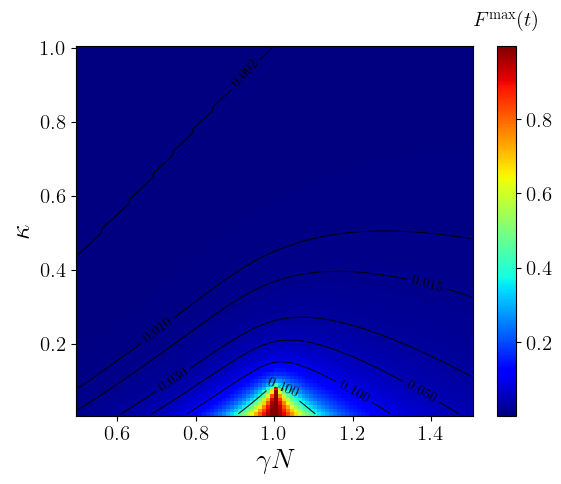

In [459]:
N = 500
kappa = np.linspace(0.01,1,100)
gamma = np.linspace(0.5/N,1.5/N,100)

x, y = np.meshgrid(gamma*N, kappa)

fig, ax = plt.subplots()
####################


minval = 0
maxval = 1


im1 = ax.pcolor(x, y, f_max, cmap='jet')

#im1 = ax.contourf(x, y, f_max, levels=np.linspace(minval, maxval,150), cmap="jet")
CS = ax.contour(x, y, f_max,levels = [0.002,0.01,0.015,0.03,0.05,0.1,0.4],colors ='black',linewidths = 0.7)
###################


cbar = fig.colorbar(
    im1,
    ax=ax,
    ticks=[0,0.2,0.4,0.6,0.8,1.0],
    orientation="vertical"
)
cbar.ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
cbar.ax.set_title(r'$F^{\rm max}(t)$', size = 15,pad = 15)

#manual_locations = [(1,2),(1,2),(1,2),(1,2),(1,2)]

#for level in CS.collections:
    #for kp,path in reversed(list(enumerate(level.get_paths()))):
        # go in reversed order due to deletions!

        # include test for "smallness" of your choice here:
        # I'm using a simple estimation for the diameter based on the
        #    x and y diameter...
        #verts = path.vertices # (N,2)-shape array of contour line coordinates
        #diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
        #print(diameter)

        #if diameter < 0.15: # threshold to be refined for your actual dimensions!
            #if remove_next:
                #del(level.get_paths()[kp])  # no remove() for Path objects:(
            #remove_next = not remove_next  # Toggle the flag

            


plt.clabel(CS, inline=True, fontsize=10)

plt.ylabel(r'$\kappa$',size = 20)
plt.xlabel(r'$\gamma N$',size = 20)

plt.gcf().canvas.draw()

#plt.savefig('../Figures/PD_fidelity_max_kappa_0-1.png',bbox_inches = 'tight',dpi =600)
plt.show()

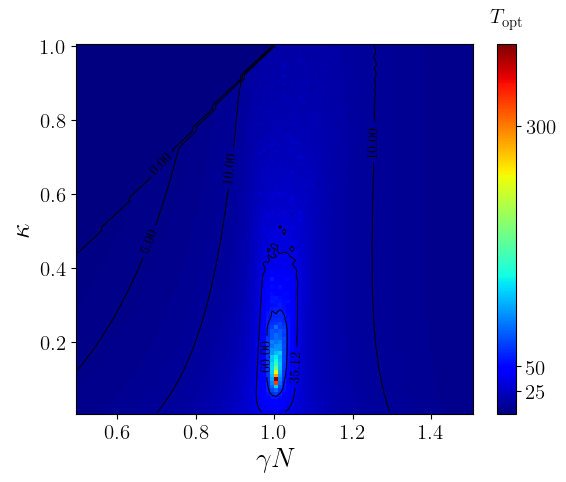

In [460]:
fig, ax = plt.subplots()
####################

minval = 0
maxval = 100

im1 = ax.pcolor(x, y, T_max,vmin = 1, cmap='jet')

#im1 = ax.contourf(x, y, T_max, levels=np.linspace(minval, maxval,150), cmap="jet")
CS = ax.contour(x, y,T_max,levels = [0,5,10,np.pi*np.sqrt(N)/2,60],colors ='black',linewidths = 0.7)
###################

cbar = fig.colorbar(
    im1,
    ax=ax,
    ticks=[0,25,50,300],
    orientation="vertical"
)
cbar.ax.set_yticklabels([0,25,50,300])
cbar.ax.set_title(r'$T_{\rm opt}$', size = 15,pad = 15)


#manual_locations = [(1,2),(1,2),(1,2),(1,2),(1,2)]

#for level in CS.collections:
   # for kp,path in reversed(list(enumerate(level.get_paths()))):
        # go in reversed order due to deletions!

        # include test for "smallness" of your choice here:
        # I'm using a simple estimation for the diameter based on the
        #    x and y diameter...
       # verts = path.vertices # (N,2)-shape array of contour line coordinates
      #  diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
      #  print(diameter)

      #  if diameter != 1999998.0981764845 and diameter != 1980728.364805822 : # threshold to be refined for your actual dimensions!
       #     del(level.get_paths()[kp])  # no remove() for Path objects:(


plt.clabel(CS, inline=True, fontsize=10)

plt.ylabel(r'$\kappa$',size = 20)
plt.xlabel(r'$\gamma N$',size = 20)

plt.gcf().canvas.draw()

plt.savefig('../Figures/PD_T_opt_kappa_0-1.png',bbox_inches = 'tight',dpi =600)

plt.show()



In [444]:
Q1 = np.zeros((len(kappa),len(gamma)))

for i in range(len(kappa)):
    for j in range(len(gamma)):

        Q1[i,j] = T_max[i,j]/f_max[i,j]

/tmp/ipykernel_1624768/1510765813.py:8: RuntimeWarning: divide by zero encountered in log
  maxval = np.max(np.log(Q1_masked))
/tmp/ipykernel_1624768/1510765813.py:11: RuntimeWarning: divide by zero encountered in log10
  im1 = ax.pcolor(x, y, np.log10(Q1_masked), cmap='jet')


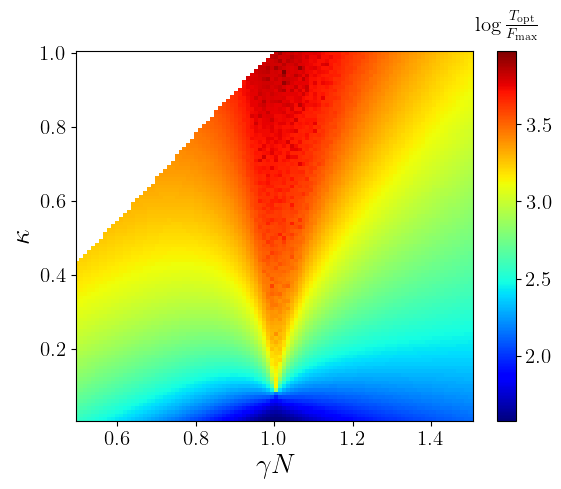

In [461]:
fig, ax = plt.subplots()
####################

# Mask out regions where z2 equals zero
Q1_masked = np.ma.masked_where(Q1== 0, Q1)

minval = np.log(0.01)
maxval = np.max(np.log(Q1_masked))

#im1 = ax.contourf(x, y, Q, levels=np.linspace(minval, maxval,150), cmap="jet")
im1 = ax.pcolor(x, y, np.log10(Q1_masked), cmap='jet')


#CS = ax.contour(x, y,Q,20,colors ='black',linewidths = 0.7)
###################

cbar = fig.colorbar(
    im1,
    ax=ax,
    #ticks=[0,1000,2000,3000,4000],
    orientation="vertical"
)
#cbar.ax.set_yticklabels([0,1000,2000,3000,4000])
cbar.ax.set_title(r'$\log \frac{T_{\rm opt}}{F_{\rm max}}$', size = 15,pad = 15)

# Overlay striped pattern on regions where z2 is zero
#ax.contourf(x, y, Q, levels=[0.5, 1.5], colors='none', hatches=['\\'], extend='both')


#manual_locations = [(1,2),(1,2),(1,2),(1,2),(1,2)]

#for level in CS.collections:
   # for kp,path in reversed(list(enumerate(level.get_paths()))):
        # go in reversed order due to deletions!

        # include test for "smallness" of your choice here:
        # I'm using a simple estimation for the diameter based on the
        #    x and y diameter...
       # verts = path.vertices # (N,2)-shape array of contour line coordinates
      #  diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
      #  print(diameter)

      #  if diameter != 1999998.0981764845 and diameter != 1980728.364805822 : # threshold to be refined for your actual dimensions!
       #     del(level.get_paths()[kp])  # no remove() for Path objects:(


#plt.clabel(CS, inline=True, fontsize=10)

plt.ylabel(r'$\kappa$',size = 20)
plt.xlabel(r'$\gamma N$',size = 20)

plt.gcf().canvas.draw()


plt.savefig('../Figures/PD_complexity_kappa_0-1.png',bbox_inches = 'tight',dpi =600)
#plt.savefig('PD_presentation_N_1000.png',bbox_inches = 'tight',dpi =600)
plt.show()


#### Survival Probability, Fidelity as a function of time

$$S(t) =  \langle \psi(t)| \psi(t) \rangle$$



In [263]:
N = 500
w  = 10
kappa = 10
gamma = [0.0002,0.001,0.002,0.003,0.004]

T = 400
dt = 0.01
m  = int(T/dt)

w_prob = np.zeros((len(gamma),m))
s_prob = np.zeros((len(gamma),m))
sn_prob = np.zeros((len(gamma),m))
sf_prob = np.zeros((len(gamma),m))

#target state
ket_w = np.zeros((N,1))
ket_w[w] = 1

for k in tqdm(range(len(gamma))):
    
    #The Hamiltonian
    H =  sf.H_CG(N,gamma[k],w,kappa)

    #initial state
    psi_0 = (1.0/np.sqrt(N))*np.ones((N,1))

    #Initial overlap
    #w_prob[k,0] =  (np.abs(np.vdot(ket_w,psi_0))**2) 
    s_prob[k,0] = np.abs(np.vdot(psi_0,psi_0))
    sn_prob[k,0] = (np.abs(np.vdot(ket_w,psi_0))**2) / np.abs(np.vdot(psi_0,psi_0))
    #sf_prob[k,0] = (np.abs(np.vdot(psi_0,psi_0))) * (np.abs(np.vdot(ket_w,psi_0))**2)

    #Time Evolution operator
    ut = np.asarray(ls.expm(-(1.0j)*H*dt))

    for j in range(1,m):        

        #wavefunction after time evolution of dt
        psit = ut.dot(psi_0)    

        # Normalized fidelity and survival probability
        #w_prob[k,j] = (np.abs(np.vdot(ket_w,psit))**2 )
        s_prob[k,j] = np.abs(np.vdot(psit,psit))
        sn_prob[k,j] = (np.abs(np.vdot(ket_w,psit))**2) / np.abs(np.vdot(psit,psit))
        #sf_prob[k,j] = np.abs(np.vdot(psit,psit)) * (np.abs(np.vdot(ket_w,psit))**2)

        psi_0 = psit  

100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


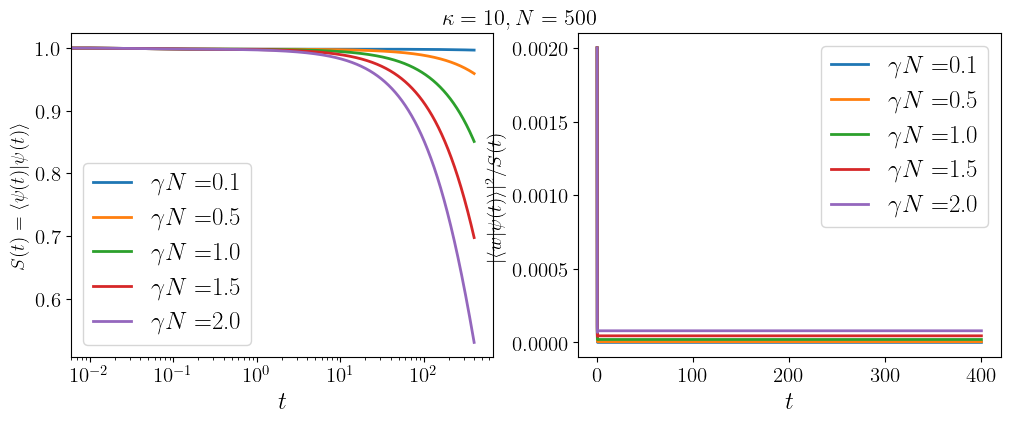

In [264]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 4 columns

##############################
ax[0].plot(np.arange(m)*dt,s_prob[0],label = f'$\\gamma N=${gamma[0]*N}')
ax[0].plot(np.arange(m)*dt,s_prob[1],label = f'$\\gamma N=${gamma[1]*N}')
ax[0].plot(np.arange(m)*dt,s_prob[2],label = f'$\\gamma N=${gamma[2]*N}')
ax[0].plot(np.arange(m)*dt,s_prob[3],label = f'$\\gamma N=${gamma[3]*N}')
ax[0].plot(np.arange(m)*dt,s_prob[4],label = f'$\\gamma N=${gamma[4]*N}')

ax[0].legend(frameon =True,loc = 'lower left')
ax[0].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$S(t) = \langle \psi(t)|\psi(t)\rangle$',fontsize = 14)
ax[0].set_xscale('log')

##############################
ax[1].plot(np.arange(m)*dt,sn_prob[0],label = f'$\\gamma N=${gamma[0]*N}')
ax[1].plot(np.arange(m)*dt,sn_prob[1],label = f'$\\gamma N=${gamma[1]*N}')
ax[1].plot(np.arange(m)*dt,sn_prob[2],label = f'$\\gamma N=${gamma[2]*N}')
ax[1].plot(np.arange(m)*dt,sn_prob[3],label = f'$\\gamma N=${gamma[3]*N}')
ax[1].plot(np.arange(m)*dt,sn_prob[4],label = f'$\\gamma N=${gamma[4]*N}')

ax[1].legend(frameon =True,loc = 'upper right')
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel(r'$|\langle w|\psi(t)\rangle|^2 / S(t)$', fontsize = 14)

##############################

# Title for the whole figure
fig.suptitle(f'$\\kappa = {kappa}, N = {N}$', fontsize=16)
fig.subplots_adjust(top=0.92)


plt.savefig(f'../Figures/Fidelity_CG_dynamics/presentation_fidelity_dynamics_kappa{kappa}-N{N}.pdf',bbox_inches = 'tight')
plt.show()

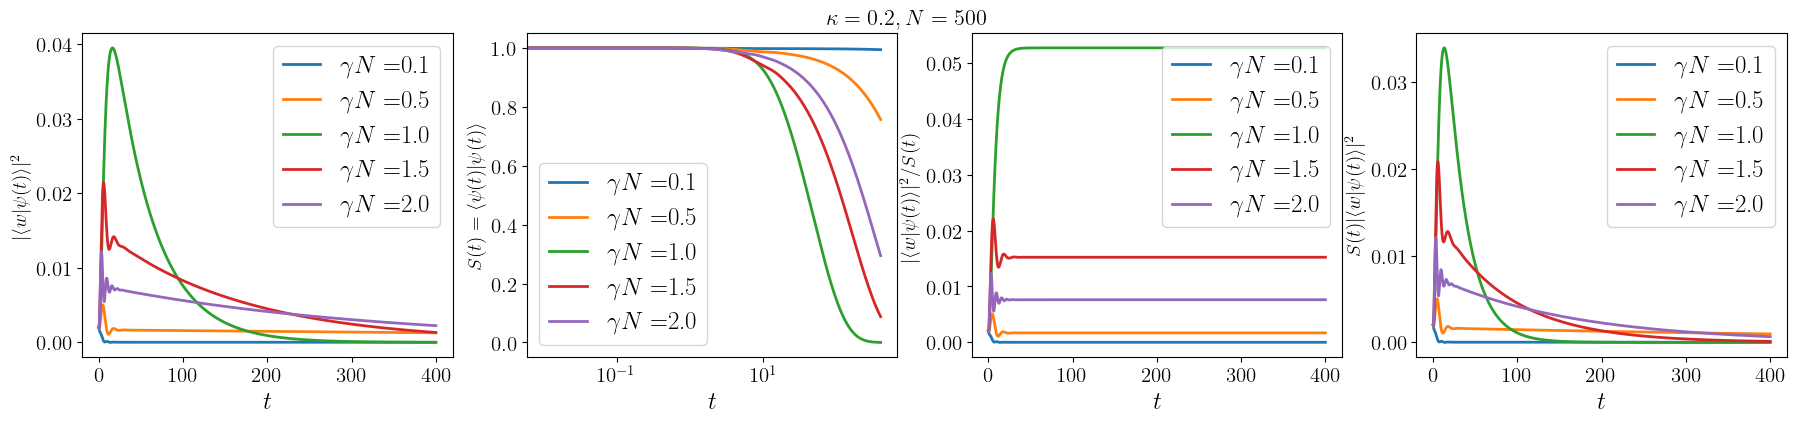

In [156]:
fig, ax = plt.subplots(1, 4, figsize=(22, 4))  # 1 row, 4 columns

ax[0].plot(np.arange(m)*dt,w_prob[0],label = f'$\\gamma N=${gamma[0]*N}')
ax[0].plot(np.arange(m)*dt,w_prob[1],label = f'$\\gamma N=${gamma[1]*N}')
ax[0].plot(np.arange(m)*dt,w_prob[2],label = f'$\\gamma N=${gamma[2]*N}')
ax[0].plot(np.arange(m)*dt,w_prob[3],label = f'$\\gamma N=${gamma[3]*N}')
ax[0].plot(np.arange(m)*dt,w_prob[4],label = f'$\\gamma N=${gamma[4]*N}')

ax[0].legend(frameon =True,loc = 'upper right')
ax[0].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$|\langle w|\psi(t)\rangle|^2$',fontsize = 14)

##############################
ax[1].plot(np.arange(m)*dt,s_prob[0],label = f'$\\gamma N=${gamma[0]*N}')
ax[1].plot(np.arange(m)*dt,s_prob[1],label = f'$\\gamma N=${gamma[1]*N}')
ax[1].plot(np.arange(m)*dt,s_prob[2],label = f'$\\gamma N=${gamma[2]*N}')
ax[1].plot(np.arange(m)*dt,s_prob[3],label = f'$\\gamma N=${gamma[3]*N}')
ax[1].plot(np.arange(m)*dt,s_prob[4],label = f'$\\gamma N=${gamma[4]*N}')


ax[1].legend(frameon =True,loc = 'lower left')
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel(r'$S(t) = \langle \psi(t)|\psi(t)\rangle$',fontsize = 14)
ax[1].set_xscale('log')

##############################
ax[2].plot(np.arange(m)*dt,sn_prob[0],label = f'$\\gamma N=${gamma[0]*N}')
ax[2].plot(np.arange(m)*dt,sn_prob[1],label = f'$\\gamma N=${gamma[1]*N}')
ax[2].plot(np.arange(m)*dt,sn_prob[2],label = f'$\\gamma N=${gamma[2]*N}')
ax[2].plot(np.arange(m)*dt,sn_prob[3],label = f'$\\gamma N=${gamma[3]*N}')
ax[2].plot(np.arange(m)*dt,sn_prob[4],label = f'$\\gamma N=${gamma[4]*N}')


ax[2].legend(frameon =True,loc = 'upper right')
ax[2].set_xlabel(r'$t$')
ax[2].set_ylabel(r'$|\langle w|\psi(t)\rangle|^2 / S(t)$', fontsize = 14)

##############################
ax[3].plot(np.arange(m)*dt,sf_prob[0],label = f'$\\gamma N=${gamma[0]*N}')
ax[3].plot(np.arange(m)*dt,sf_prob[1],label = f'$\\gamma N=${gamma[1]*N}')
ax[3].plot(np.arange(m)*dt,sf_prob[2],label = f'$\\gamma N=${gamma[2]*N}')
ax[3].plot(np.arange(m)*dt,sf_prob[3],label = f'$\\gamma N=${gamma[3]*N}')
ax[3].plot(np.arange(m)*dt,sf_prob[4],label = f'$\\gamma N=${gamma[4]*N}')


ax[3].legend(frameon =True,loc = 'upper right')
ax[3].set_xlabel(r'$t$')
ax[3].set_ylabel(r'$S(t)|\langle w|\psi(t)\rangle|^2$',fontsize = 14)


# Title for the whole figure
fig.suptitle(f'$\\kappa = {kappa}, N = {N}$', fontsize=16)
fig.subplots_adjust(top=0.92)


plt.savefig(f'../Figures/Fidelity_CG_dynamics/fidelity_dynamics_kappa{kappa}-N{N}.pdf',bbox_inches = 'tight')
plt.show()